# DLC Grasp Pipeline

## Setup
### Unzip uploads and create zip files for download as needed

In [ ]:
import zipfile as zf
files = zf.ZipFile('/home/erg629/Projects/Pop_left_hand-eric-2021-07-02/training-datasets/iteration-104.zip', 'r')
files.extractall('/home/erg629/Projects/Pop_left_hand-eric-2021-07-02/training-datasets/')
files.close()

In [ ]:
from zipfile import ZipFile
import os
from os.path import basename

with ZipFile('folder_struct_test.zip', 'w') as zipObj:
    for folderName, subfolders, filenames in os.walk('/home/erg629/Projects/Pop_left_hand-eric-2021-07-02/dlc-models'):
        for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))

## DLC pipeline (2D stage)
### Setup environment. Edit config file as needed for current model iteration, frame sets, etc.

In [ ]:
import os
os.environ['DLClight']='True'
#os.environ['CUDA_VISIBLE_DEVICES']='1'
import pandas as pd
import tensorflow as tf
import deeplabcut

In [ ]:
project_name = 'Pop_left_hand-eric-2021-07-02/'

home_dir = '/home/erg629/Projects/'
path_config_file = os.path.join(home_dir, project_name, 'config.yaml')

### Create training data set, train and evaluate network

In [ ]:
deeplabcut.create_training_dataset(path_config_file, augmenter_type='imgaug')

In [ ]:
deeplabcut.train_network(path_config_file, maxiters=500000, max_snapshots_to_keep=10)#,gputouse=1)

In [ ]:
deeplabcut.evaluate_network(path_config_file, plotting=False) #, gputouse=1

### Analyze videos and create labeled videos for reference.
#### Note: if manually cropping, you will need to run videos one at a time and change the window in the config file each time

In [ ]:
#NS
#cam_0_crop = [x1 y1 x2 y2]
#cam_1_crop = [x1 y1 x2 y2]
#cam_2_crop = [x1 y1 x2 y2]
#cam_3_crop = [x1 y1 x2 y2]
#NS

video_names = ['20210830_cam_0.avi']#,'20210816_cam_1.avi','20210816_cam_2.avi','20210816_cam_3.avi']
#video_names = ['20210830_gopro_trimmed.mp4']#, '20210830_gopro_1_1.mp4']
date = '20210830'
iteration = 'iteration-1012'
vidfolder = os.path.join(home_dir, project_name, 'videos', date)

videofile_path = []
for vid in video_names:
    videofile_path.append(os.path.join(vidfolder, vid))
    
destfolder = os.path.join(vidfolder, iteration)

if not os.path.exists(destfolder):
    print('Destination folder does not exist. Creating one right now...')
    os.mkdir(destfolder)
#NS 
# loop for editing config file
    
deeplabcut.analyze_videos(path_config_file, videofile_path, destfolder=destfolder, shuffle=1, trainingsetindex=-1, save_as_csv=True, videotype='avi',batchsize=64)#, dynamic=(True,.5,10))#, videotype='mp4', batchsize=64)
# NS End loop

In [ ]:
deeplabcut.create_labeled_video(path_config_file, videofile_path, videotype="mp4", destfolder=destfolder)

### Uncrop the manually cropped outputs

In [ ]:
#NS
# See matlab unCrop.m file

### Other useful utilities - as needed

In [ ]:
deeplabcut.__version__

In [ ]:
deeplabcut.extract_save_all_maps(path_config_file, Indices=[0, 5, 10, 15, 20])

In [ ]:
deeplabcut.convertcsv2h5(path_config_file, userfeedback='True')

## Post-processing

### Install requirements

In [ ]:
pip install -r requirements.txt

### Setup
#### A lot of this may not be necessary if we're cutting out 2D interpolation; should revisit

In [ ]:
import re
import os
import pandas as pd
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

#cams = ['20210814_cam_0', '20210814_cam_1', '20210814_cam_2', '20210814_cam_3']
cams = ['cam_0', 'cam_1', 'cam_2', 'cam_3']
postfix = 'DLC_resnet_50_Pop_freeReach_0317_mergedApr19shuffle1_180000_full.pickle'
iteration = 19
session_folder = '20210828'
calib_folder = '20210814/calib'

os_path = '/home/erg629/Projects//Pop_freeReach_0317_merged-Min-2020-04-19/videos/'
calib_path = os.path.join(os_path, calib_folder)
pickle_folder =  os.path.join(os_path, session_folder, 'iteration-'+str(iteration))
pickle_paths = [os.path.join(pickle_folder, cam+postfix) for cam in cams]
paths_to_save_raw_csv = [os.path.join(pickle_folder, cam+'.csv') for cam in cams]

joints = ['Wrist', 'CMC_thumb', 'MCP_thumb', 'MCP1', 'MCP2', 'MCP3', 'MCP4',
          'IP_thumb', 'PIP1', 'PIP2', 'PIP3', 'PIP4', 'Dip1', 'Dip2', 'Dip3', 'Dip4',
          'Tip_thumb', 'Tip1', 'Tip2', 'Tip3', 'Tip4']

fingers = [[
  ["Wrist", "CMC_thumb"],
  ["CMC_thumb", "MCP_thumb"],
  ["MCP_thumb", "IP_thumb"],
  ["IP_thumb", "Tip_thumb"]],
    
  [["Wrist", "MCP1"],
  ["MCP1", "PIP1"],
  ["PIP1", "Dip1"],
  ["Dip1", "Tip1"]],
    
  [["Wrist", "MCP2"],
  ["MCP2", "PIP2"],
  ["PIP2", "Dip2"],
  ["Dip2", "Tip2"]],

  [["Wrist", "MCP3"],
  ["MCP3", "PIP3"],
  ["PIP3", "Dip3"],
  ["Dip3", "Tip3"]],
    
  [["Wrist", "MCP4"],
  ["MCP4", "PIP4"],
  ["PIP4", "Dip4"],
  ["Dip4", "Tip4"]]]

# Measured connection length in mm
dist_meds_real = {'Wrist-CMC_thumb': [23.77, 20.83, 23.26],
                  'CMC_thumb-MCP_thumb': [18.73, 24.96, 22.56],
                  'MCP_thumb-IP_thumb': [14.25, 18.23, 17.72],
                  'IP_thumb-Tip_thumb': [11.66, 9.87, 10.53],
                  'Wrist-MCP1': [43.86, 42.38, 35.63],
                  'Wrist-MCP2': [42.81, 39.57, 35.35],
                  'Wrist-MCP3': [42.81, 37.46, 36.32],
                  'Wrist-MCP4': [40.50, 40.22, 36.89],
                  'MCP1-PIP1': [26.32, 27.40, 25.19],
                  'MCP2-PIP2': [30.07, 33.44, 30.00],
                  'MCP3-PIP3': [30.27, 32.70, 28.53],
                  'MCP4-PIP4': [21.95, 24.52, 24.44],
                  'PIP1-Dip1': [18.01, 16.92, 13.58],
                  'PIP2-Dip2': [23.08, 20.38, 18.19],
                  'PIP3-Dip3': [21.98, 21.16, 20.16],
                  'PIP4-Dip4': [18.29, 18.25, 14.78],
                  'Dip1-Tip1': [11.54, 12.82, 11.55],
                  'Dip2-Tip2': [16.18, 15.39, 12.98],
                  'Dip3-Tip3': [14.72, 13.34, 14.15],
                  'Dip4-Tip4': [11.17, 11.64, 10.57]}

### 3D reconstruction
#### Lots of setup in this config file; be particularly careful about paths and make sure dates are the same

In [ ]:
from utils.utils import load_config
from calibration.intrinsic import calibrate_intrinsic
from calibration.extrinsic import calibrate_extrinsic

config = load_config('config_pop_left.toml')

In [ ]:
calibrate_intrinsic(config)
calibrate_extrinsic(config)

In [ ]:
from triangulation.triangulate import reconstruct_3d_ransac
recovery = reconstruct_3d_ransac(config, 2, model_type='hrnet')

   ### Subtracting common average/ center of mass

In [ ]:
#NS

### Outlier removal and filtering
#### Currently reconsidering where and how this should be implemented

In [ ]:
#NS
from post_processing.outlier_removal import outlier_speed_removal, \
    outlier_connection_removal

from post_processing.filtering import filter_3d

# Representative speed threshold for points of interest in m/s
# Speed of  PIP:  0.75 m/s
#           DIP:  0.9  m/s
#           Tip:  1.2  m/s
#           rest: 0.6  m/s
speed_thr = [0.6, 0.75, 0.9, 1.2]
# This function removes any outlier points that passed over the speed threshold
# This function will save "output_3d_data_speed.csv" inside "pickle_folder"
outlier_speed_removal(config, joints, speed_thr)

# This function 1) removes any connection that is outside of (0.6*med, 1.4*med) range,
#               2) and then (med-2*std, med+2*std)
# This function will save "output_3d_data_out1.csv" and "output_3d_data_out2.csv"
outlier_connection_removal(config, fingers)

# This function perfrom 1) interpolation, 2) filter, and 3) remove outlier connection
# There are two kinds of interpolation methods: linear ('linear') and cubic spline ('spline')
# Interpolate at most 4 missing consecutive data
# There are three kinds of filter you can use: lpf, savgol, None
# lpf: 8 Hz zero-phase low pass filter (output_3d_data_lpf.csv)
# savgol: Savitzky–Golay filter with 5th order and window size of 7 (output_3d_data_savgol.csv)
# None: Doesn't apply filter, it just perform interpolation (output_3d_data_None.csv)
interp_type = 'spline'
filt_type = 'lpf'
filter_3d(config, joints, fingers, interp_type, filt_type)

### PPCA

In [ ]:
import numpy as np
import pandas as pd
import _ppca as pp

#From https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def nan_interp(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

#From https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

csv_in = r"C:\Users\nstoy\Documents\DLC\dlc_post-processing_code\ppca\20210816_output_3d_data_raw.csv"
csv_out = r"C:\Users\nstoy\Documents\DLC\dlc_post-processing_code\ppca\20210816_output_3d_data_raw_pyinterp_ppca7.csv"
py_interp = r"C:\Users\nstoy\Documents\DLC\dlc_post-processing_code\ppca\20210816_output_3d_data_raw_pyinterp.csv"
max_acceptable_nans = 2
isinterp = False
isvelocity = False
number_PCs_pos = 7
number_PCs_vel = 7
frame_rate = 30

if isvelocity:
    number_PCs = number_PCs_vel
else:
    number_PCs = number_PCs_pos

data_frame_in = pd.read_csv(csv_in)
cols = data_frame_in.columns
d1 = data_frame_in.to_numpy()
if isinterp:
    col_index_relevant = [i for i in range(d1.shape[1])] #For working with synthetic data
else:
    col_index_relevant = [i for i in range(d1.shape[1]-2) if i%5<3]
d1_relevant = d1[:,col_index_relevant] #Get the first 3 columns associated with each joint; they contain x, y, and z.
if isvelocity:
    d1_relevant = (d1_relevant[2:, :]-d1_relevant[:-2, :]) * frame_rate

nan_locations = np.isnan(d1_relevant)

long_sequences = []
for j in range(d1_relevant.shape[1]):
    h = nan_locations[:, j]
    run_length, position, _ = rle(h)
    for i in range(len(position)):
        if h[position[i]] and (run_length[i] > max_acceptable_nans):
            long_sequences.append((position[i], run_length[i], j))
            
    d1_relevant[:,j]=nan_interp(d1_relevant[:,j])

df = pd.DataFrame(data=d1_relevant)
df.to_csv(py_interp, index=False, header=False)

#Removing the center of mass
#center_of_mass = d1_relevant.mean(1)
#d1_relevant = d1_relevant - center_of_mass

it99 = pp.PPCA()
it99.fit(d1_relevant, d=number_PCs, tol=1e-6)
it99_ppca = it99.inverse_transform()
it99_ppca = it99_ppca * it99.stds + it99.means

#Adding the center of mass
#it99_ppca = it99_ppca + center_of_mass

#Replacing NaNs in long runs
for k in long_sequences:
    it99_ppca[k[0]:k[0]+k[1], k[2]] = np.nan

data_frame_out = pd.DataFrame(data=it99_ppca, columns=cols[col_index_relevant])
data_frame_out.to_csv(csv_out, index=False)

#### Right now the contrib module blocks DLC from seeing openCV...this is my hacky bandaid

In [ ]:
pip uninstall opencv-contrib-python

## Multiview Bootstrapping

In [ ]:
import os
from multiview_bootstrapping import MVB
from utils.utils import load_config
from utils.calibration_utils import get_video_path

In [ ]:
config = load_config('config_pop.toml')
data_path = os.path.join(config['triangulation']['reconstruction_output_path'], 'output_3d_data_lpf.csv')

mvb = MVB(config, data_path)

mvb.select_good_frames(criterion='measured', cutoff=4, N=1000)

#### Another place to be careful about paths and dates. Hopefully this can be streamlined in the future

In [ ]:
project_folder_path = '/home/myp7435/Pop_freeReach_0317_merged-Min-2020-04-19/labeled-data'
save_paths = [os.path.join(project_folder_path, 'cam_'+str(i)+'_1217') for i in range(4)]

video_folder_path = '/home/myp7435/downsampled_videos/1217/experiment'
video_paths = [os.path.join(video_folder_path, 'cam_'+str(i)+'.mp4') for i in range(4)]

_, _, vid_indices = get_video_path(config)

img_format = 'png'

scorer = 'Min'
individuals = 'right_hand'

mvb.bootstrap(video_paths, save_paths, vid_indices, img_format, scorer, individuals)

In [ ]:
image_save_paths = [os.path.join('/home/myp7435/test', 'cam_'+str(i)+'_1217') for i in range(4)]

mvb.check_mvb_images(video_paths, image_save_paths, save_paths)

## Now add the bootstrapped images to your config file and start all over!

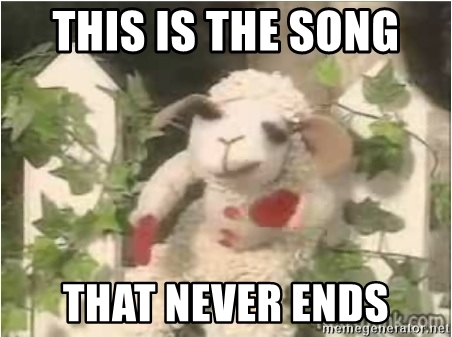